In [1]:
!pip install torch
!pip install torchvision
!pip install pycocotools
!pip install xmltodict

Looking in indexes: https://artifacts.jpmchase.net/artifactory/api/pypi/pypi/simple/
Looking in indexes: https://artifacts.jpmchase.net/artifactory/api/pypi/pypi/simple/
Looking in indexes: https://artifacts.jpmchase.net/artifactory/api/pypi/pypi/simple/
Looking in indexes: https://artifacts.jpmchase.net/artifactory/api/pypi/pypi/simple/


In [2]:
import os
import numpy as np
import torch
import torchvision
import pycocotools
import pandas as pd
from PIL import Image
from torch.utils.data import Subset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.nn as nn
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from collections import Counter
import xmltodict
import statistics

In [3]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print(torch.cuda.get_device_name(1))
    print(torch.cuda.get_device_name(2))
    print(torch.cuda.get_device_name(3))
    print('Memory Usage:')
    print('Allocated:- ', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:-   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

True
4
0
NVIDIA A10G
Using device: cuda

NVIDIA A10G
NVIDIA A10G
NVIDIA A10G
NVIDIA A10G
Memory Usage:
Allocated:-  0.0 GB
Cached:-    0.0 GB


In [4]:
img_names=[] 
xml_names=[] 
for dirname, _, filenames in os.walk('MaskedFace/train'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]!="xml":
            img_names.append(filename)
        else:
            xml_names.append(filename)

In [5]:
# Image sizes
#img1 = Image.open("train/mask-000.png").convert('RGB')
#print(img1.size)

In [6]:
path_annotations="MaskedFace/train/" 
listing=[]
img_width=[]
img_height=[]
for i in img_names[:]:
    #print(i)
    with open(path_annotations+i[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    
    Image_sizes = doc["annotation"]["size"]
    
    img_width.append(Image_sizes["width"])
    img_height.append(Image_sizes["height"])
    
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])
        

Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items,'\n',values)

print("Image Sizes:-")
print("Minimum Width:-")
print(min(img_width))
print("Minimum Height:-")
print(min(img_height))

print("Mean Sizes of Images:-")
print(statistics.mean(map(int,img_width)))
print(statistics.mean(map(int,img_height)))

dict_keys(['with_mask', 'without_mask', 'mask_weared_incorrect']) 
 dict_values([2912, 658, 111])
Image Sizes:-
Minimum Width:-
193
Minimum Height:-
156
Mean Sizes of Images:-
370.25814863103
309.99087353324643


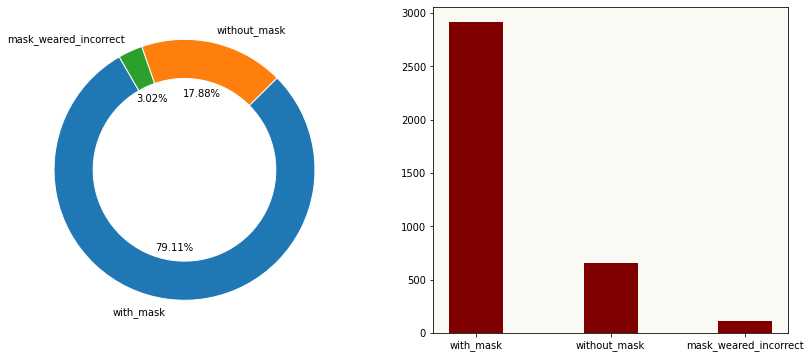

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie(values,wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=Items, radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(Items, list(values),
              color ='maroon',width = 0.4)

plt.show()

In [8]:
class_str2num = {'with_mask': 1,'without_mask': 2,'mask_weared_incorrect': 3}
class_num2str = {v: k for k, v in class_str2num.items()}

In [9]:
class_str2num

{'with_mask': 1, 'without_mask': 2, 'mask_weared_incorrect': 3}

In [10]:
annotations_list = sorted(os.listdir('MaskedFace/annotations'))

In [11]:
annotations_list[:5]

['mask-000.xml',
 'mask-001.xml',
 'mask-002.xml',
 'mask-003.xml',
 'mask-004.xml']

In [12]:
import xml.etree.ElementTree as ET
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bboxes = []
    labels = []
    filename = root.find('filename').text
    for boxes in root.iter('object'):
        ymin, xmin, ymax, xmax = None, None, None, None
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        box = [xmin, ymin, xmax, ymax]
        bboxes.append(box)
        labels.append(int(class_str2num[boxes.find("name").text]))
    return filename, bboxes, labels

Index
108
mask-123.png
[1, 1]


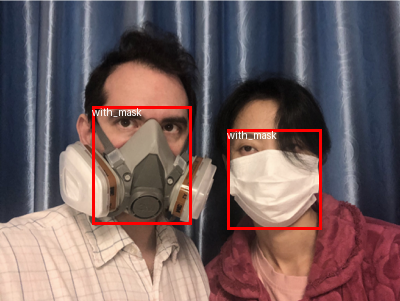

In [13]:
from PIL import Image, ImageDraw
idx = np.random.randint(len(annotations_list))
print("Index")
print(idx)
filename, boxes, labels = parse_xml(os.path.join('MaskedFace/train', annotations_list[idx]))
print(filename)
#print(boxes)
print(labels)
image = Image.open(os.path.join('MaskedFace/train', filename))
#print the bounding box on the image.
draw = ImageDraw.Draw(image)
for i, ibox in enumerate(boxes):
    draw.rectangle([(ibox[0], ibox[1]), (ibox[2], ibox[3])], outline='red', width=3)
    draw.text((ibox[0], ibox[1]), text=class_num2str[labels[i]])
image

In [14]:
class MaskedDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.annotations_list = sorted(os.listdir(os.path.join(root, 'annotations')))

    def __getitem__(self, indx):
        
        # load annotation
        filename, boxes, labels = parse_xml(os.path.join(self.root, 'annotations', self.annotations_list[indx]))
        
        # load image
        img_path = os.path.join(self.root, 'train', filename)
        img = Image.open(img_path).convert('RGB')
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        num_objs = boxes.shape[0]
        
        #classes
        labels = torch.tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([indx])
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] =iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    
    def __len__(self):
        return len(self.annotations_list)

boxes
tensor([1, 1, 1, 1, 1, 1, 1, 1, 2])
labels
tensor([1, 1, 1, 1, 1, 1, 1, 1, 2])
image_id
tensor([1, 1, 1, 1, 1, 1, 1, 1, 2])
area
tensor([1, 1, 1, 1, 1, 1, 1, 1, 2])
iscrowd
tensor([1, 1, 1, 1, 1, 1, 1, 1, 2])
Boxes:-
tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]])


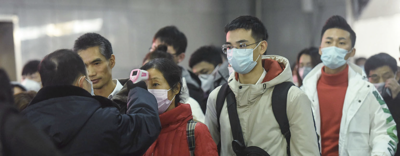

In [15]:
dataset = MaskedDataset(root='MaskedFace')
img, target = dataset.__getitem__(1)

boxes={}
for k,v in target.items():
    print(k)
    #print(v)
    print(target['labels'])
    boxes = target['boxes']  

print("Boxes:-")
print(boxes)
        
img

In [16]:
def get_model_from_file(num_classes, flag=True):   
    # Load an object detection model pretrained on MS COCO.
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=flag, weights_backbone=flag)
    # Load the fasterrcnn resnet50.
    #chk = torch.load('fasterrcnn_resnet50_fpn_coco-258fb6c6.pth')
    # Load state dictionary.
    #model.load_state_dict(chk)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # return model.
    return model

In [17]:
'''
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}
'''

"\nimage_transforms = {\n    # Train uses data augmentation\n    'train':\n    transforms.Compose([\n        transforms.Resize(size=(224,224)),\n        transforms.RandomRotation(degrees=15),\n        transforms.ColorJitter(),\n        transforms.RandomHorizontalFlip(),\n        transforms.ToTensor(),\n        transforms.Normalize([0.485, 0.456, 0.406],\n                             [0.229, 0.224, 0.225])  # Imagenet standards\n    ]),\n    # Validation does not use augmentation\n    'test':\n    transforms.Compose([\n        transforms.Resize(size=(224,224)),\n        transforms.ToTensor(),\n        transforms.Normalize([0.485, 0.456, 0.406], \n                             [0.229, 0.224, 0.225])\n    ])\n}\n"

In [18]:
def get_transform(train):
    #Transform of the images.
    transform_list= []
    
    transform_list.append(v2.PILToTensor())
    transform_list.append(v2.ConvertImageDtype(torch.float))
    
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        # This configuration best for training.
        # transform_list.append(v2.Resize((256,256), antialias=None))
        # transform_list.append(v2.RandomResizedCrop(size=(224, 224), antialias=True))
        # transform_list.append(v2.ColorJitter())
        transform_list.append(v2.RandomHorizontalFlip(0.5))
        # Random affine not working well at lower epochs.
        # transform_list.append(v2.RandomAffine(15))   
        # Image resize transformation does not work well for this training.
        # transform_list.append(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
        # transform_list.append(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    # else:
        # transform_list.append(v2.Resize((256,256), antialias=None))
        # transform_list.append(v2.RandomResizedCrop(size=(224, 224), antialias=True))
        # transform_list.append(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
        # transform_list.append(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
        
    transform_object = v2.Compose(transform_list)
    
    return transform_object

In [19]:
'''
def get_transform(train):
    #Transform of the images.
    transform_list= []
    transform_list.append(v2.PILToTensor())
    transform_list.append(v2.ConvertImageDtype(torch.float))
    
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        # This configuration best for training.
        transform_list.append(v2.RandomHorizontalFlip(0.5))
        # Random affine not working well at lower epochs.
        # transform_list.append(v2.RandomAffine(5))   
        # Image resize transformation does not work well for this training.
        # transform_list.append(v2.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)))
        
    transform_object = v2.Compose(transform_list)
    
    return transform_object
'''  

'\ndef get_transform(train):\n    #Transform of the images.\n    transform_list= []\n    transform_list.append(v2.PILToTensor())\n    transform_list.append(v2.ConvertImageDtype(torch.float))\n    \n    if train:\n        # during training, randomly flip the training images\n        # and ground-truth for data augmentation\n        # This configuration best for training.\n        transform_list.append(v2.RandomHorizontalFlip(0.5))\n        # Random affine not working well at lower epochs.\n        # transform_list.append(v2.RandomAffine(5))   \n        # Image resize transformation does not work well for this training.\n        # transform_list.append(v2.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)))\n        \n    transform_object = v2.Compose(transform_list)\n    \n    return transform_object\n'

In [20]:
Tobj = get_transform(train=True)
Tobj1 = get_transform(train=False)
print(Tobj)
print(Tobj1)

Compose(
      PILToTensor()
      ConvertImageDtype()
      RandomHorizontalFlip(p=0.5)
)
Compose(
      PILToTensor()
      ConvertImageDtype()
)


In [21]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [22]:
train_dataset = MaskedDataset(root= 'MaskedFace', transforms = get_transform(train=True))

In [23]:
import multiprocessing as mp

cpu_count = mp.cpu_count()

print(cpu_count-1)

47


In [24]:
from time import time
import multiprocessing as mp

# Checking the optimal num of workers for loading the training dataset.
# for num_workers in range(2, mp.cpu_count(), 2):  
    #train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
    #start = time()
    #for epoch in range(1, 3):
        #for i, data in enumerate(train_loader, 0):
        #    pass
    #end = time()
    #print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

In [25]:
# test_dataset = MaskedDataset(root='.', transforms=get_transform(train=False))
# dataset
#indices = torch.randperm(len(train_dataset)).tolist()
# A subset of the above original datasets are used for quick training and
# testing iterations
#train_dataset = Subset(train_dataset, indices[:-10])
#test_dataset = Subset(test_dataset, indices[-10:])
# data loader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=18, collate_fn=collate_fn)
#test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)
#print("We have: {} examples, {} are training and {} testing".format(len(indices), len(train_dataset), len(test_dataset)))
print("We have: {} are training".format(len(train_dataset)))

We have: 767 are training


In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
num_classes = len(class_str2num) + 1
print("Classes:-")
print(num_classes)
# get the model using our helper function
model = get_model_from_file(num_classes)
# print(model)
# move model to the GPU Device.
model.to(device)
print("Model Loaded to : {}".format(device))

cuda
Classes:-
4


/opt/omniai/software/Miniconda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/omniai/software/Miniconda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model Loaded to : cuda


In [27]:
# construct an optimizer
#params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

### This works best. The best combination of the training and optimization.
#from engine import train_one_epoch, evaluate
#import utils
# let's train it for 10 epochs
#num_epochs = 1000
#for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    #train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # evaluate on the test dataset
    #evaluate(model, test_loader, device=device)
    # update the learning rate
    #lr_scheduler.step()

In [ ]:
%%time
# Epoch Counts.
num_epochs = 1000
# Parameters.
params = [p for p in model.parameters() if p.requires_grad]
# Optimizer.
# Adding the nesterov momentum variable.
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# Adam optimizer not working well in this scenario.
# optimizer = torch.optim.Adam(params, lr=0.005, weight_decay=0.0005)
# length of training dataloader.
len_dataloader = len(train_loader)

# LR Scheduler of the optimizer.
# StepLR is not converging well.
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Linear LR is converging well. for warmup factor 0.01 and warmup_iters = min(100,len(train_loader)-1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=13, gamma=0.2)

# losses for each epochs.
ep_loss_list=[]
# Linear LR is also coverging well.
for epoch in range(num_epochs):
    
    # Model to be in training mode.
    model.train()
    
    i = 0 
    epoch_loss = 0
    
    lr_scheduler_inter_epoch = None
    
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(train_loader) - 1)

        lr_scheduler_inter_epoch = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=warmup_factor, total_iters=warmup_iters)
    
    # iterate on the train_loader.
    for imgs, targets in train_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(imgs,targets)
        losses = sum(loss for loss in loss_dict.values())        
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
        
        if lr_scheduler_inter_epoch is not None:
            lr_scheduler_inter_epoch.step()
        
    # StepLR for lr_scheduler.
    lr_scheduler.step()
    
    # Save the model checkpoint after every 10 epochs.
    e_loss =  np.round(epoch_loss.detach().cpu().numpy(), decimals=2)
    ep_loss_val = round(e_loss)
    #print("E Loss")
    #print(ep_loss_val)
    #print(type(ep_loss_val))
    ep_loss_list.append(ep_loss_val)
    
    #if (epoch % 10) == 0:
    #    print(f'Epoch:{epoch}, Epoch_Loss: {epoch_loss}')
    
    # Save the model every 50 iterations.
    if (epoch % 50) == 0:
        print(f'Epoch:{epoch}, Epoch_Loss: {epoch_loss}')
        torch.save(model.state_dict(),'trained_model_faster_rcnn_epoch_{}_loss_{}.pth'.format(epoch,ep_loss_val))
    
    # Save the lowest loss model state.
    # if ep_loss_val <= min(ep_loss_list):
    #    torch.save(model.state_dict(),'trained_model_faster_rcnn_epoch_{}_loss_{}.pth'.format(epoch,ep_loss_val))
    
    # print in the intervals of 100.
    if (epoch % 300) == 0:
        print(f'Epoch:{epoch}, Epoch_Loss: {epoch_loss}')

Epoch:0, Epoch_Loss: 112.22820281982422
Epoch:0, Epoch_Loss: 112.22820281982422
Epoch:1, Epoch_Loss: 83.38172912597656
Epoch:2, Epoch_Loss: 77.65055084228516
Epoch:3, Epoch_Loss: 73.94573974609375
Epoch:4, Epoch_Loss: 71.73577117919922
Epoch:5, Epoch_Loss: 70.38410949707031
Epoch:6, Epoch_Loss: 71.0013427734375
Epoch:7, Epoch_Loss: 69.82500457763672
Epoch:8, Epoch_Loss: 71.8604965209961
Epoch:9, Epoch_Loss: 68.87017059326172
Epoch:10, Epoch_Loss: 70.15481567382812
Epoch:11, Epoch_Loss: 66.78334045410156
Epoch:12, Epoch_Loss: 66.89920806884766
Epoch:13, Epoch_Loss: 61.320919036865234
Epoch:14, Epoch_Loss: 57.27632522583008
Epoch:15, Epoch_Loss: 54.28899002075195
Epoch:16, Epoch_Loss: 52.72881317138672
Epoch:17, Epoch_Loss: 51.99470520019531
Epoch:18, Epoch_Loss: 47.12518310546875
Epoch:19, Epoch_Loss: 45.973487854003906
Epoch:20, Epoch_Loss: 46.525421142578125
Epoch:21, Epoch_Loss: 43.3855094909668
Epoch:22, Epoch_Loss: 41.86102294921875
Epoch:23, Epoch_Loss: 40.68061828613281
Epoch:24,

In [ ]:
# Put Flag="True" for downloading the model and not using the 
# downloaded model.
def load_model_from_file(num_classes, filename, flag=True):   
    # Load an object detection model pretrained on MS COCO.
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=flag, weights_backbone=flag)
    # Load the fasterrcnn resnet50.
    chk = torch.load(filename)
    # Load state dictionary.
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # return model.
    model.load_state_dict(chk)
    
    return model

In [ ]:
model_filename = 'trained_model_faster_rcnn_epoch_730_loss_66.44000244140625.pth'
loaded_model = load_model_from_file(num_classes, model_filename)

In [ ]:
val_dataset = MaskedDataset(root='test_imgs', transforms=get_transform(train=False))
print(len(val_dataset))
# data loader
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=12, collate_fn=collate_fn)

In [ ]:
infer_model = loaded_model.cpu()
infer_model.eval()
print("Evaluation Mode of Model:-")

In [ ]:
from collections import Counter

print("Class numbers")
print(class_num2str)

def calculate_MAPE(test_dataset, confidence_score, model):
    
    class_score = 0
    class_score_ind=[]
    
    for i in range(len(test_dataset)):
        
        img, _ = test_dataset[i]
        
        with torch.no_grad():
            # Prediction for the particular image.
            prediction = model([img])
        
        groundtruth_labels = test_dataset[i][1]['labels'].numpy()
        confident_prediction_labels=[]
        
        # For all the predicted boxes check the labels and confidence scores.
        for element in range(len(prediction[0]['boxes'])):

            #print("Prediction Label of each box:-")
            ele_pred_label = prediction[0]['labels'][element].cpu().item()
            #print(ele_pred_label)
            
            score = np.round(prediction[0]['scores'][element].cpu().numpy(), decimals= 4)
            # if the score is greater than confidence score.
            if score > confidence_score:
               # print(score)
               # if  the score is greater than the confidence score
               confident_prediction_labels.append(ele_pred_label)
        
        #print("The confident prediction labels:-")
        #print(confident_prediction_labels)
        C_grd = Counter(groundtruth_labels)
        #print(C_grd)
        C_pred = Counter(confident_prediction_labels)   
        #print(C_pred)
        
        # Classes in the Object detection:-
        # print(class_num2str)
        class_score=0
        # Class keys.
        for k in class_num2str.keys():
            # print("Class Labels:-")
            # print(k)
            At = C_grd[k]
            Pt = C_pred[k] 
            class_score += abs(At-Pt)/max(At,1)
            
        class_score_ind.append(class_score)
    
    sum_scores = sum(class_score_ind)
    print("Scores_sum")
    print(sum_scores)
    #print("Class Scores:-")
    #print(class_score)  
    #print("Class_score_List:-")
    #print(class_score_ind)
    #print("length of class scores:-")
    #print(len(class_score_ind))
    #print("length of test dataset")
    #print(len(test_dataset))
    MAPE = sum_scores / (len(class_num2str.keys()))
    Avg_MAPE = (MAPE/len(test_dataset)) * 100
    print("Avg MAPE Score on the dataset")
    print(Avg_MAPE)
    
confidence_score = 0.4
calculate_MAPE(val_dataset, confidence_score, infer_model)

In [ ]:
# Count masked faces
def count_masks(test_dataset, model):
    
    len_dataset = len(test_dataset)
    
    inference_results_matrix = np.zeros((len_dataset,3))

    for i in range(len(val_dataset)):
        img, _ = val_dataset[i]
        
        with torch.no_grad():
            prediction = model([img])
    
        for element in range(len(prediction[0]['boxes'])):
            label = prediction[0]['labels'][element].cpu().item()
            score = np.round(prediction[0]['scores'][element].cpu().numpy(), decimals= 4)
            if score > 0.4:
               inference_results_matrix[i][label-1] += 1 
            
    return inference_results_matrix

In [ ]:
%%time
inf_results = count_masks(val_dataset, infer_model)
print(inf_results.shape)

In [ ]:
inf_results[1:5]

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams['figure.dpi'] = 72
model = model.cpu()
model.eval()
for i in range(len(val_dataset)):
    img, _ = val_dataset[i]
    label_boxes = np.array(val_dataset[i][1]['boxes'])
    #put the model in evaluation mode
    with torch.no_grad():
        prediction = model([img])
    image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    draw = ImageDraw.Draw(image)
    # draw groundtruth
    for elem in range(len(label_boxes)):
        draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]), (label_boxes[elem][2], label_boxes[elem][3])], outline ="yellow", width =3)
    for element in range(len(prediction[0]['boxes'])):
        box = prediction[0]['boxes'][element].cpu().numpy()
        label = prediction[0]['labels'][element].cpu().item()
        score = np.round(prediction[0]['scores'][element].cpu().numpy(), decimals= 4)
        if score > 0.4:
            draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline ='blue', width =3)
            draw.text((box[0], box[1]), text = class_num2str[label] + ', ' + str(score))
    plt.imshow(image)
    plt.show()